In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

Carregando os datasets

In [41]:
circle_ds = np.load('data/circle_subset_2000.npy')
square_ds = np.load('data/square_subset_2000.npy')
triangle_ds = np.load('data/triangle_subset_2000.npy')

circle_ds = circle_ds.reshape((-1, 28, 28))
square_ds = square_ds.reshape((-1, 28, 28))
triangle_ds = triangle_ds.reshape((-1, 28, 28))

print(circle_ds.shape)
print(square_ds.shape)
print(triangle_ds.shape)

(2000, 28, 28)
(2000, 28, 28)
(2000, 28, 28)


Verificação das imagens

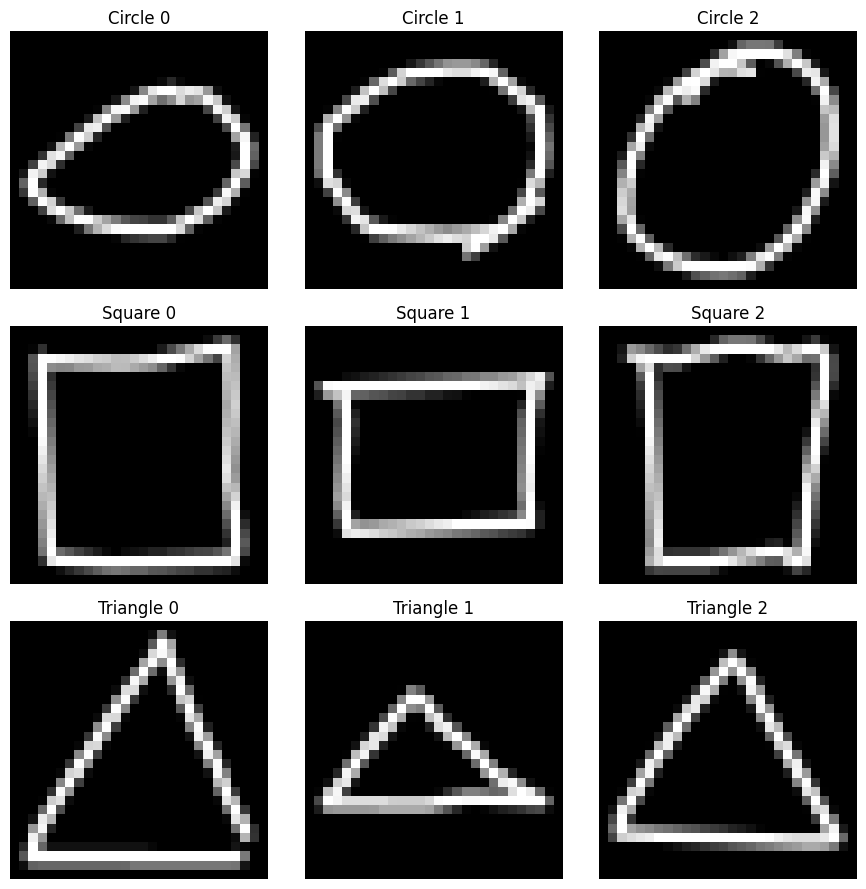

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

# 3 círculos
for i in range(3):
    axs[0, i].imshow(circle_ds[i], cmap='gray')
    axs[0, i].set_title(f'Circle {i}')
    axs[0, i].axis('off')

# 3 quadrados
for i in range(3):
    axs[1, i].imshow(square_ds[i], cmap='gray')
    axs[1, i].set_title(f'Square {i}')
    axs[1, i].axis('off')

# 3 triângulos
for i in range(3):
    axs[2, i].imshow(triangle_ds[i], cmap='gray')
    axs[2, i].set_title(f'Triangle {i}')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

Concatenação dos datasets e reshape

In [43]:
# juntar as imagens
X = np.concatenate([circle_ds, square_ds, triangle_ds], axis=0)

# criar os rótulos
y_circle   = np.zeros(circle_ds.shape[0], dtype=int)   # classe 0
y_square   = np.ones(square_ds.shape[0], dtype=int)    # classe 1
y_triangle = np.full(triangle_ds.shape[0], 2, dtype=int)  # classe 2

y = np.concatenate([y_circle, y_square, y_triangle], axis=0)

print(X.shape)  # (6000, 28, 28)
print(y.shape)  # (6000,)

print("Antes da normalização:", X.min(), X.max())  # 0 -> 255
X = X.astype("float32") / 255.0

print("Depois da normalização:", X.min(), X.max())  # 0.0 -> 1.0

X = X.reshape(-1, 28, 28, 1)

print("Novo shape de X:", X.shape)

(6000, 28, 28)
(6000,)
Antes da normalização: 0 255
Depois da normalização: 0.0 1.0
Novo shape de X: (6000, 28, 28, 1)


Split treino/validação/teste

In [44]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size    = 0.2,
    random_state = 42,
    stratify     = y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size    = 0.5,
    random_state = 42,
    stratify     = y_temp
)

print("Train: ", X_train.shape, y_train.shape)
print("Val: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (4800, 28, 28, 1) (4800,)
Val:  (600, 28, 28, 1) (600,)
Test:  (600, 28, 28, 1) (600,)


In [45]:
batch_size = 32
buffer_size = 1000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .shuffle(buffer_size, seed=42)  
    .batch(batch_size)              
    .prefetch(AUTOTUNE)             
)

val_ds = (
    val_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

for imgs, labels in train_ds.take(1):
    print(imgs.shape, labels.shape)
    # (32, 28, 28, 1) (32,)


(32, 28, 28, 1) (32,)


Arquitetura da CNN

In [46]:
num_classes = 3


model_2conv = models.Sequential([
    #1 camada conv
    layers.Conv2D(
        filters =32,
        kernel_size= (3, 3),
        activation='relu',
        input_shape=(28, 28, 1)
        ),
    layers.MaxPooling2D((2, 2)),

    #2 camada conv
    layers.Conv2D(
        filters =64,
        kernel_size= (3, 3),
        activation='relu',
        ),
        
    layers.MaxPooling2D((2, 2)), 

    layers.Flatten(),

    layers.Dense(128, activation='relu'),

    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model_2conv.summary()

c:\Users\lucam\Documents\Code\ML\CNN\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,131 (875.51 KB)

 Trainable params: 224,131 (875.51 KB)

 Non-trainable params: 0 (0.00 B)

Compile

In [48]:
initial_lr = 1e-3

model_2conv.compile(
    optimizer=optimizers.Adam(learning_rate=initial_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Callbacks

In [49]:
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights=True,
    verbose=1
)

Treinando o modelo

In [ ]:
history = model_2conv.fit(
    train_ds,
    validation_data  =val_ds,
    epochs           =20,
    callbacks        =[reduce_lr, early_stopping]
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9219 - loss: 0.2244 - val_accuracy: 0.9733 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0864 - val_accuracy: 0.9733 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0725 - val_accuracy: 0.9767 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.0584 - val_accuracy: 0.9767 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0519 - val_accuracy: 0.9717 - val_loss: 0.0764 - learning_rate: 0.0010
Epoch 6/20
139/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0408
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0452 - v

Avaliar teste

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9767 - loss: 0.0780
Test loss: 0.07796167582273483
Test accuracy: 0.9766666889190674
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Relatório de classificação:

              precision    recall  f1-score   support

     círculo       0.97      0.97      0.97       200
    quadrado       0.98      0.96      0.97       200
   triângulo       0.98      0.99      0.99       200

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Matriz de confusão:
 [[195   2   3]
 [  6 193   1]
 [  1   1 198]]


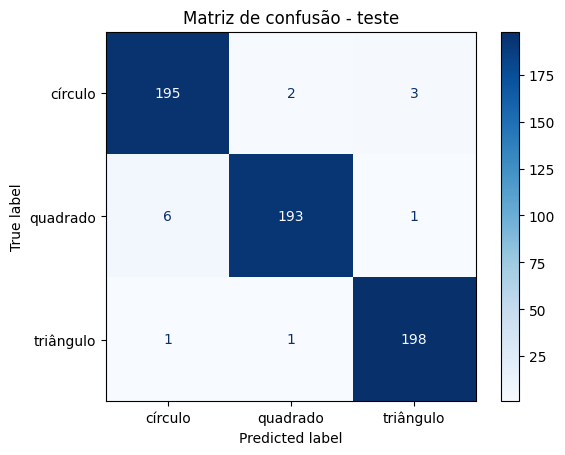

In [54]:
test_loss, test_acc = model_2conv.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc )

# Probabilidades previstas pelo modelo no conjunto de teste
y_prob = model_2conv.predict(test_ds)         

# Classe prevista = índice da maior probabilidade (softmax)
y_pred = np.argmax(y_prob, axis=1) 

# Rótulos verdadeiros
y_true = y_test

# precision, recall, f1 por classe
print("Relatório de classificação:\n")
print(classification_report(y_true, y_pred, target_names=["círculo", "quadrado", "triângulo"]))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusão:\n", cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["círculo", "quadrado", "triângulo"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusão - teste")
plt.show()



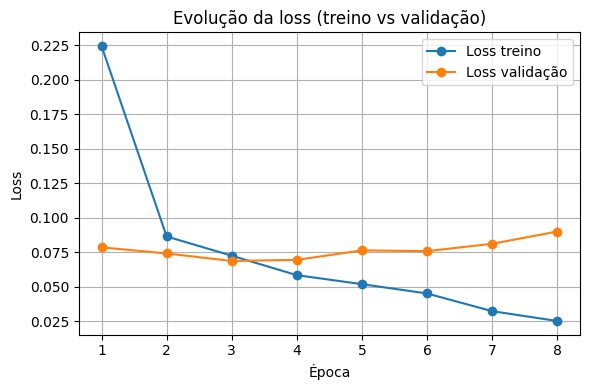

In [52]:
# Pega as métricas salvas pelo Keras
hist = history.history

train_loss = hist["loss"]
val_loss   = hist["val_loss"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, "o-", label="Loss treino")
plt.plot(epochs, val_loss, "o-", label="Loss validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolução da loss (treino vs validação)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


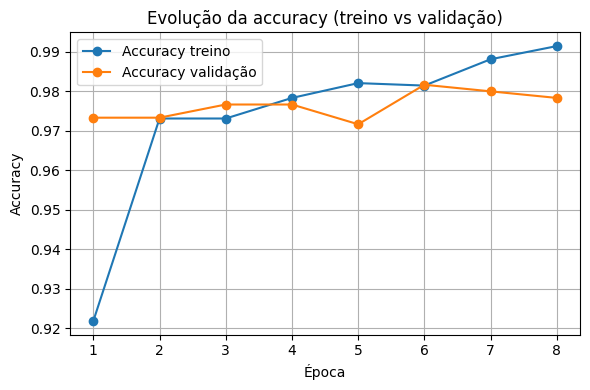

In [53]:
train_acc = hist["accuracy"]
val_acc   = hist["val_accuracy"]

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, "o-", label="Accuracy treino")
plt.plot(epochs, val_acc, "o-", label="Accuracy validação")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolução da accuracy (treino vs validação)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
